In [1]:
import numpy as np
import torch
%matplotlib inline
from matplotlib import pyplot as plt
import tqdm
import torch.nn.functional as F
import torch.nn as nn
import pickle
import fb_utils as fb
from torch.utils.data import DataLoader
import random
import os

from model import TDFilterbank
from dataset import NTVOW
from losses import KappaLoss

In [2]:
# set seed
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(0)
np.random.seed(0)


In [3]:
config = {
        "N": 4095,
        "J": 42,
        "T": 1024,
        "sr": 16000,
        "fmin": 64,
        "fmax": 8000,
        "stride": 585,
        "batch_size": 64,
        "epochs": 10,
    }

data_dir="/Users/felixperfler/Documents/ISF/Random-Filterbanks/NTVOW"

random_filterbank = fb.random_filterbank(config["N"], config["J"], config["T"], tight=False, support_only=True)
target = 'MEL'
# get current working directory of file
cwd = os.path.abspath('')

with open(cwd+'/targets/'+target+'.pkl', 'rb') as fp:
    target_filterbank = pickle.load(fp)["freqz"]
    target_filterbank = torch.from_numpy(target_filterbank.T)

# device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cpu'

In [4]:
model_baseline = TDFilterbank(config, random_filterbank)
model_baseline.to(device)
model_kappa = TDFilterbank(config, random_filterbank)
model_kappa.to(device)

TDFilterbank(
  (psi): Conv1d(1, 42, kernel_size=(1024,), stride=(585,), bias=False)
)

In [5]:
train_dataset = NTVOW(data_dir, 'train', config, target_filterbank)
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)

val_dataset = NTVOW(data_dir, 'val', config, target_filterbank)
val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=True)

In [6]:
loss_baseline = KappaLoss(beta=0)
loss_kappa = KappaLoss(beta=1e-2)

In [7]:
optimizer_baseline = torch.optim.Adam(model_baseline.parameters(), lr=1e-5)
optimizer_kappa = torch.optim.Adam(model_kappa.parameters(), lr=1e-5)

In [8]:
fit_baseline = []
fit_val_baseline = []
fit_kappa = []
fit_val_kappa = []
kappa_baseline = []
kappa_val_baseline = []
kappa_kappa = []
kappa_val_kappa = []

w = model_baseline.psi.weight.detach().numpy()[:,0,:]
w = np.pad(w, ((0,0),(0, config["N"]-config["T"])), constant_values=0)
A,B = fb.frame_bounds_lp(w)
kappa_baseline.append(B/A)
kappa_val_baseline.append(B/A)

w = model_kappa.psi.weight.detach().numpy()[:,0,:]
w = np.pad(w, ((0,0),(0, config["N"]-config["T"])), constant_values=0)
A,B = fb.frame_bounds_lp(w)
kappa_kappa.append(B/A)
kappa_val_kappa.append(B/A)

print(f"Init condition numbers:")
print(f"\tBaseline condition number {kappa_baseline[-1]:.2f}")
print(f"\tKappa condition number {kappa_kappa[-1]:.2f}")

for epoch in range(config["epochs"]):
    running_loss = 0.0
    running_kappa = 0.0

    running_val_loss = 0.0
    running_val_kappa = 0.0

    model_baseline.train()
    model_kappa.train()

    for batch in train_loader:
        x = batch['x'].to(device)
        x_out = batch['x_out'].to(device)
        
        x_out_baseline = model_baseline(x)
        base_loss_i, _ = loss_baseline(x_out_baseline, x_out)
        
        x_out_kappa = model_kappa(x)
        w = model_kappa.psi.weight[:,0,:]
        w = F.pad(w,(0,config["N"]-config["T"]), value=0)
        base_loss_kappa_i, loss_kappa_i = loss_kappa(x_out_kappa, x_out, w)

        optimizer_baseline.zero_grad()
        base_loss_i.backward()
        optimizer_baseline.step()

        optimizer_kappa.zero_grad()
        loss_kappa_i.backward()
        optimizer_kappa.step()

        running_loss += base_loss_i.item()
        running_kappa += base_loss_kappa_i.item()
    
    model_baseline.eval()
    model_kappa.eval()
    with torch.no_grad():
        for batch in val_loader:
            x = batch['x'].to(device)
            x_out = batch['x_out'].to(device)
            
            x_out_baseline = model_baseline(x)
            base_loss_i, _ = loss_baseline(x_out_baseline, x_out)
            
            x_out_kappa = model_kappa(x)
            w = model_kappa.psi.weight[:,0,:]
            w = F.pad(w,(0,config["N"]-config["T"]), value=0)
            base_loss_kappa_i, loss_kappa_i = loss_kappa(x_out_kappa, x_out, w)

            running_val_loss += base_loss_i.item()
            running_val_kappa += base_loss_kappa_i.item()

    w = model_baseline.psi.weight.detach().numpy()[:,0,:]
    w = np.pad(w, ((0,0),(0, config["N"]-config["T"])), constant_values=0)
    A,B = fb.frame_bounds_lp(w)
    kappa_baseline.append(B/A)
    
    w = model_kappa.psi.weight.detach().numpy()[:,0,:]
    w = np.pad(w, ((0,0),(0, config["N"]-config["T"])), constant_values=0)
    A,B = fb.frame_bounds_lp(w)
    kappa_kappa.append(B/A)

    fit_baseline.append(running_loss/len(train_loader))
    fit_kappa.append(running_kappa/len(train_loader))

    w = model_baseline.psi.weight.detach().numpy()[:,0,:]
    w = np.pad(w, ((0,0),(0, config["N"]-config["T"])), constant_values=0)
    A,B = fb.frame_bounds_lp(w)
    kappa_val_baseline.append(B/A)
    
    w = model_kappa.psi.weight.detach().numpy()[:,0,:]
    w = np.pad(w, ((0,0),(0, config["N"]-config["T"])), constant_values=0)
    A,B = fb.frame_bounds_lp(w)
    kappa_val_kappa.append(B/A)

    fit_val_baseline.append(running_val_loss/len(val_loader))
    fit_val_kappa.append(running_val_kappa/len(val_loader))


    print(f"Epoch {epoch+1}/{config['epochs']}:")
    print(f"\tBaseline Loss: {fit_baseline[-1]:.2f} with condition number {kappa_baseline[-1]:.2f}")
    print(f"\tKappa Loss: {fit_kappa[-1]:.2f} with condition number {kappa_kappa[-1]:.2f}")
    print(f"\tBaseline Val Loss: {fit_val_baseline[-1]:.2f} with condition number {kappa_val_baseline[-1]:.2f}")
    print(f"\tKappa Val Loss: {fit_val_kappa[-1]:.2f} with condition number {kappa_val_kappa[-1]:.2f}")

    # if fit_kappa[-1] - fit_baseline[-1] > 1e-25:
    #     loss_kappa.beta = loss_kappa.beta/2
    #     print(f"\tDecreasing kappa loss weight to {loss_kappa.beta:.2e}")
    # elif fit_kappa[-1] - fit_baseline[-1] < -1e-25:
    #     loss_kappa.beta = loss_kappa.beta*2
    #     print(f"\tIncreasing kappa loss weight to {loss_kappa.beta:.2e}")

Init condition numbers:
	Baseline condition number 3.02
	Kappa condition number 3.02
Epoch 1/10:
	Baseline Loss: 0.09 with condition number 3.02
	Kappa Loss: 0.10 with condition number 1.80
	Baseline Val Loss: 0.08 with condition number 3.02
	Kappa Val Loss: 0.09 with condition number 1.80
Epoch 2/10:
	Baseline Loss: 0.09 with condition number 3.02
	Kappa Loss: 0.09 with condition number 1.65
	Baseline Val Loss: 0.08 with condition number 3.02
	Kappa Val Loss: 0.08 with condition number 1.65
Epoch 3/10:
	Baseline Loss: 0.08 with condition number 3.02
	Kappa Loss: 0.08 with condition number 1.58
	Baseline Val Loss: 0.07 with condition number 3.02
	Kappa Val Loss: 0.08 with condition number 1.58
Epoch 4/10:
	Baseline Loss: 0.08 with condition number 3.02
	Kappa Loss: 0.08 with condition number 1.51
	Baseline Val Loss: 0.07 with condition number 3.02
	Kappa Val Loss: 0.07 with condition number 1.51
Epoch 5/10:
	Baseline Loss: 0.07 with condition number 3.02
	Kappa Loss: 0.08 with conditio

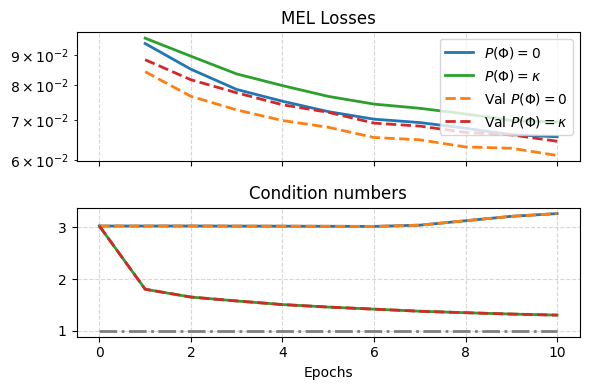

In [9]:
# plot losses and condition numbers over epochs

plt.rcParams['text.usetex'] = False

fig, axes = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
Ts = np.arange(0, config['epochs']+1)

ax = axes[0]
ax.plot(Ts[1:], fit_baseline, 'tab:blue', linewidth=2, label='$P(\Phi)=0$')
ax.plot(Ts[1:], fit_kappa, 'tab:green', linewidth=2, label='$P(\Phi)=\kappa$')
ax.plot(Ts[1:], fit_val_baseline, 'tab:orange', linewidth=2, linestyle='--', label='Val $P(\Phi)=0$')
ax.plot(Ts[1:], fit_val_kappa, 'tab:red', linewidth=2, linestyle='--', label='Val $P(\Phi)=\kappa$')

ax.set_yscale('log')
ax.set_title(target+' Losses')
ax.grid(linestyle='--', alpha=0.5)

ax = axes[1]
ax.plot(Ts, kappa_baseline, 'tab:blue', linewidth=2)
ax.plot(Ts, kappa_kappa, 'tab:green', linewidth=2)
ax.plot(Ts, kappa_val_baseline, 'tab:orange', linewidth=2, linestyle='--')
ax.plot(Ts, kappa_val_kappa, 'tab:red', linewidth=2, linestyle='--')
ax.plot(Ts, np.ones(len(Ts)), 'tab:gray', linewidth=2, label='Tightened', linestyle='-.')

ax.set_title('Condition numbers')
ax.set_xlabel('Epochs')
axes[0].legend(loc='upper right')
ax.grid(linestyle='--', alpha=0.5)

plt.tight_layout()


In [10]:
target_filterbank.shape

torch.Size([42, 4095])